<a href="https://colab.research.google.com/github/pseudope/sgparrot2021Lv1-1/blob/main/Simpsons/Simpsons_Classification_20210511_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons Classification

In [1]:
import os
import glob
import zipfile

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical, Sequence

### for notebook users
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


## 저장된 npz 파일 불러오기
구글드라이브에서 불러오는 데에 상당히 오래 걸리기 때문에, 한 번 불러온 후 npz 파일로 저장해놓은 상황

In [3]:
target = ["bart", "charles_montgomery", "krusty", "lisa_simpson",
            "marge_simpson", "milhouse_van_houten", "moe_szyslak",
            "ned_flanders", "principal_skinner"]

category = {0: "bart", 1: "charles_montgomery", 2: "krusty", 3: "lisa_simpson",
            4: "marge_simpson", 5: "milhouse_van_houten", 6: "moe_szyslak",
            7: "ned_flanders", 8: "principal_skinner"}

In [4]:
train_dataset = np.load("/content/gdrive/MyDrive/Colab Notebooks/simpsons/train_128_npz.npz")
test_dataset = np.load("/content/gdrive/MyDrive/Colab Notebooks/simpsons/test_128_npz.npz")

In [5]:
X_train = train_dataset["X_train_npz"]
y_train = train_dataset["y_train_npz"]

y_train = to_categorical(y_train, len(target))

X_test = test_dataset["X_test_npz"]
y_test_list = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/simpsons/test_sample.csv")
y_test = np.array(y_test_list["files"])

In [6]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (11248, 128, 128, 3)
y_train shape: (11248, 9)
X_test shape: (1086, 128, 128, 3)
y_test shape: (1086,)


## Data Processing & Data Inspection

In [7]:
train_batch_size = 128
test_batch_size = 128
image_size = 128


### 그냥 원본으로 불러서 원하는 해상도로 crop할지 고민 중
augmentor_train = A.Compose([
                             A.HorizontalFlip(p=0.5),
                             A.ShiftScaleRotate(p=0.5),
                             A.RandomBrightnessContrast(
                                 brightness_limit=(-0.25, 0.25),
                                 contrast_limit=(-0.25, 0.25), p=1
                                 ),   # 밝기와 대비 조절
                             A.CLAHE(p=1),   # Contrast-Limited Adaptive Histogram Equalization
                             A.Cutout(num_holes = 16, max_h_size=2,
                                      max_w_size=2, p=0.75),   # dropout
                             A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
])
augmentor_test = A.Compose([A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))])

### Defining Dataloader

In [8]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size,
                 augmentor= None, shuffle=False):   # augmentor가 추가됨

        """
        x_set, y_set: train set or test set (np.ndarray)
        batch_size: the size of data when a batch is enumerated (int)
        augmentor: data augmentor (albumantation, imgaug, ...)
        shuffle: whether shuffle the data or not after each epoch (boolean)
        """

        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size: (idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        # batch_size 쓰면 마지막 batch에서 문제 발생
        # 대안으로 indices.shape[0] 사용
        image_batch = np.zeros((indices.shape[0], image_size, image_size, 3))

        for image_index in range(indices.shape[0]):

            ### 이 안에서 다룰지, 밖에서 해결할지 고민 중
            ### image = cv2.cvtColor(cv2.imdead(indices.shape[image_index]), cv2.COLOR_BGR2RGB)
            ### image = cv2.resize(image, (image_size, image_size))

            image = batch_x[image_index]

            if self.augmentor is not None:
                image = self.augmentor(image=image)["image"]

            batch_x[image_index] = image
        
        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [9]:
train_loader = Dataloader(X_train, y_train, batch_size=train_batch_size, augmentor=augmentor_train, shuffle=True)
test_loader = Dataloader(X_test, y_test, batch_size=test_batch_size, augmentor=augmentor_test, shuffle=True)

In [10]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (128, 9)
Data  : (128, 128, 128, 3)


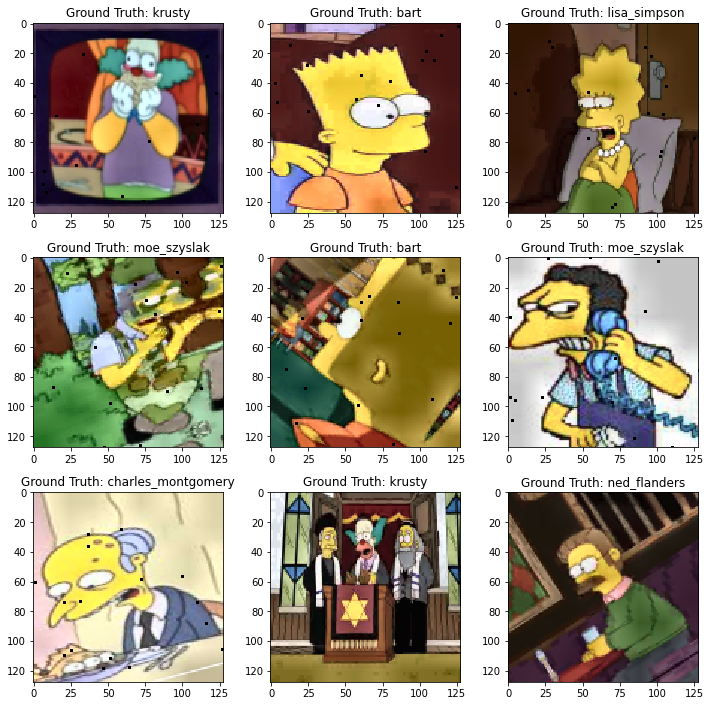

In [11]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(category.get(int(target))))

plt.show()

In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (128,)
Data  : (128, 128, 128, 3)


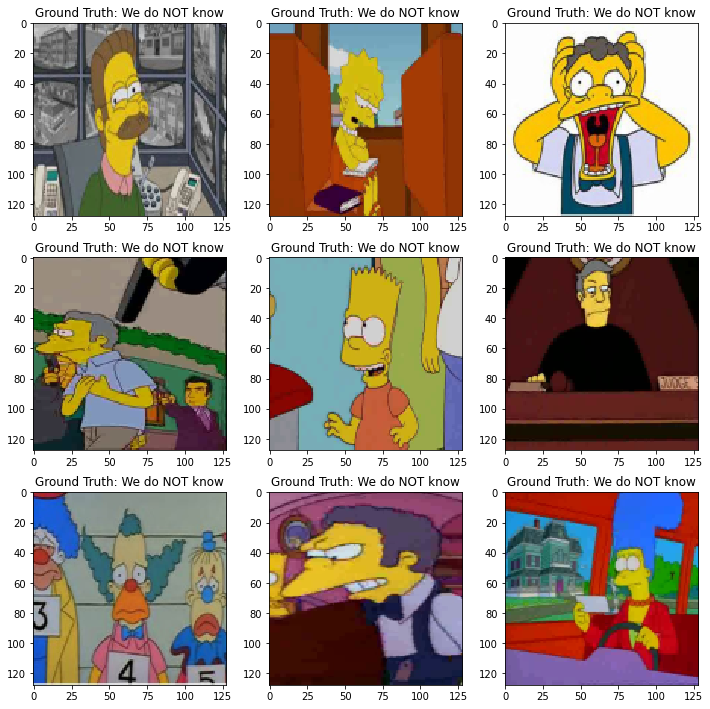

In [13]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format("We do NOT know"))

plt.show()

## CNN Modeling